## CLASSIFICATION: UNCLASSIFIED

## Recurrent Neural Net Example: LSTM Model
### Learning from Alice in Wonderland

Recurrent Neural Nets (RNN) are used to model problems that involve seqences of inputs; they have loops that add feedback and memory over time. The leading RNN models are currently the LSTM (long short-term memory) model and the GRU (gated recurrent units) model. For a good introduction to LSTM nets, see the external blog: "colah.github.io/posts/2015-08-Understanding-LSTMs" 
or the recent deep learning book by Goodfellow, Bengio and Courville.

In a nutshell, LSTM units contain the following building blocks:

* input gates: to model the information to keep,
* forget gates: to model the information to drop, and
* output gates.

We illustrate the use of LSTM to learn the style of the novel 'Alice in wonderland' at the character level.


In [1]:
from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 5103)


## Reading the text

We read the text file from the novel 'Alice in worderland', map all letters to lowercase, and build dictionaries mapping characters to integers.

In [2]:
## read in text from Alice in Wonderland
import get_data
get_data.get_file("wonderland.txt", "../data/")

raw_text = open('../data/wonderland.txt').read()
raw_text = raw_text.lower() ## lowercase
drop = {'\ufeff'}           ## character(s) to drop 
s = raw_text.translate({ord(i):None for i in drop}) 
text = ' '.join(s.split())
chars = sorted(list(set(text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))
n_chars = len(text) 
n_vocab = len(chars)

## Build training sequences

We build training sequences as follows:
    
* X_train: build all sequences of length 100 from the text 
* Y_train: the character immediately following each sequence in X_train


In [3]:
## sequences: 100-long sequences of chars with 1-long output (next char)
seq_len = 100
X_train = []
Y_train = []
for i in range(0, n_chars - seq_len, 1):
    seq_in = text[i:i+seq_len]
    seq_out = text[i+seq_len]
    X_train.append([char_to_int[char] for char in seq_in])
    Y_train.append(char_to_int[seq_out])
n_patterns = len(X_train)
print ("Total patterns:", n_patterns)
X = np.reshape(X_train, (n_patterns, seq_len))
Y = np_utils.to_categorical(Y_train)

Total patterns: 142309


## The model

We build a simple model with only 4 components, namely:

* Embedding: map the characters into 64-dim space
* LSTM: the long short-term memory unit with 256-dim output
* Dropout: to reduce possible overfitting issues
* Dense: with output dimension equal to the number of distinct characters


In [4]:
## Long short-term memory model (LSTM) with Embedding
lstm = Sequential()
lstm.add(Embedding(n_vocab,64,input_length=seq_len))
lstm.add(LSTM(256))
lstm.add(Dropout(0.25))
lstm.add(Dense(Y.shape[1], activation='softmax'))
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           2816      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               328704    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 44)                11308     
Total params: 342,828.0
Trainable params: 342,828.0
Non-trainable params: 0.0
_________________________________________________________________


## Building the LSTM and saving the weights

Training a LSTM model can be quite slow, so we set checkpoints to save the weights, so we do not need to re-train each time. 


In [5]:
## Build a new model ...
#lstm.compile(loss='categorical_crossentropy', optimizer='adam')
#filepath = "Alice-weights-{epoch:02d}-{loss:.4f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
#callback_list = [checkpoint]
#lstm.fit(X, Y, epochs=10, batch_size=128, callbacks=callback_list)


## Loading the weights

If we already have a trained model, this is how we can load the weights.


In [6]:
## ... or load weights
fn = 'Alice-weights-09-0.8870.hdf5'
lstm.load_weights(fn)
lstm.compile(loss='categorical_crossentropy', optimizer='adam')


In [7]:
## random seed: strta from a string within the book
start = np.random.randint(0, len(X_train)-1)
pattern = X_train[start]
print ("Seed:")
print("\"",''.join([int_to_char[value] for value in pattern]),"\"")
print ("Following:")
follow = X_train[start+seq_len]
print("\"",''.join([int_to_char[value] for value in follow]),"\"")


Seed:
" .’ ‘you’ll see me there,’ said the cat, and vanished. alice was not much surprised at this, she was  "
Following:
" getting so used to queer things happening. while she was looking at the place where it had been, it  "


In [8]:
import sys
## generate characters from the model
for i in range(seq_len):
    x = np.reshape(pattern, (1,len(pattern)))
    prediction = lstm.predict(x, verbose=0)
    index = np.argmax(prediction) ## most likely character
    result = int_to_char[index]
    #seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]


a little side of the soldiers with a great hurry and the baby, and the party was sitting on the same

In [9]:
## Look inside the box - character embeddings
from keras.models import Model
embed = Model(inputs=lstm.input, outputs=lstm.layers[0].output)
pattern = [x%n_vocab for x in range(seq_len)]
x = np.reshape(pattern, (1,len(pattern)))
E = embed.predict(x)[0,0:n_vocab,:]


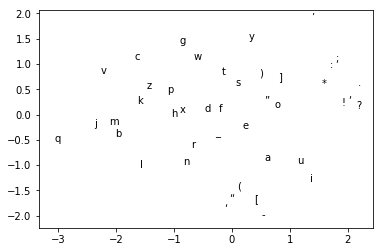

In [10]:
from sklearn.manifold import TSNE
## t-SNE and plot
data = pd.DataFrame(E)
# Carry out tsne dimensionality reduction and make a results dataframe
tsne = TSNE(perplexity=25, n_iter_without_progress=10, learning_rate=30)
vizdata = pd.DataFrame(tsne.fit_transform(data), columns=['x', 'y'])
fig, ax = plt.subplots()
ax.scatter(vizdata.x, vizdata.y, marker='.', c='white')
for i, txt in enumerate(chars):
    ax.annotate(txt, (vizdata.x[i], vizdata.y[i]))
